In [1]:
import sys
import os

sys.path.append(r'C:\Program Files\QGIS 3.22.3\apps\qgis\python') #this is important for loading qgis library
sys.path.append(r'C:\Program Files\QGIS 3.22.3\apps\qgis\python\plugins') #this is important for loading processing library

In [2]:
import qgis
from qgis.gui import *
from qgis.core import *
from qgis.utils import plugins
from PyQt5.QtCore import *
from qgis.analysis import QgsNativeAlgorithms

# Day 1 - Part III Introduction to PYQGIS <img src="./Resources/sla.png" width="100" align ="right"/>

This session will get you started on learning how to use PyQGIS code to increase your GIS efficiency. There are several ways to use PyQGIS in QGIS Desktop including: 

* Automatically run Python code when QGIS starts
* Issue commands in the Python console within QGIS
* Create and use plugins
* Create processing algorithms
* Create functions for expressions in QGIS
* Create standalone custom applications based on the QGIS API

Next Thursday, we will learn how to run commands in Python console and how to create standalone custom applications based on QGIS API.

Next Thursday, we will focus on the plugin and procesing development. You will be able to run complex workflows with the click of a button instead of clicking through multiple tools to recreate results. The skills learned in this course (Session 5) will also help you develop custom plugins for QGIS.

This course is just an introduction to PYQGIS. For all details, see [PyQGIS Developer Cookbook](https://docs.qgis.org/3.16/en/docs/pyqgis_developer_cookbook/index.html) and [QGIS Python API](https://qgis.org/pyqgis/master/) for the ultimate references.

The second part of this session introduces techniques for effectively loading, manipulating, and visualizing geospatial data in Python. These techniques are fundamental to the process of doing geospatial data science.

## Use PYQGIS in QGIS

In this section, we will use QGIS Python Console to run the programm and use Sublime text for editing.

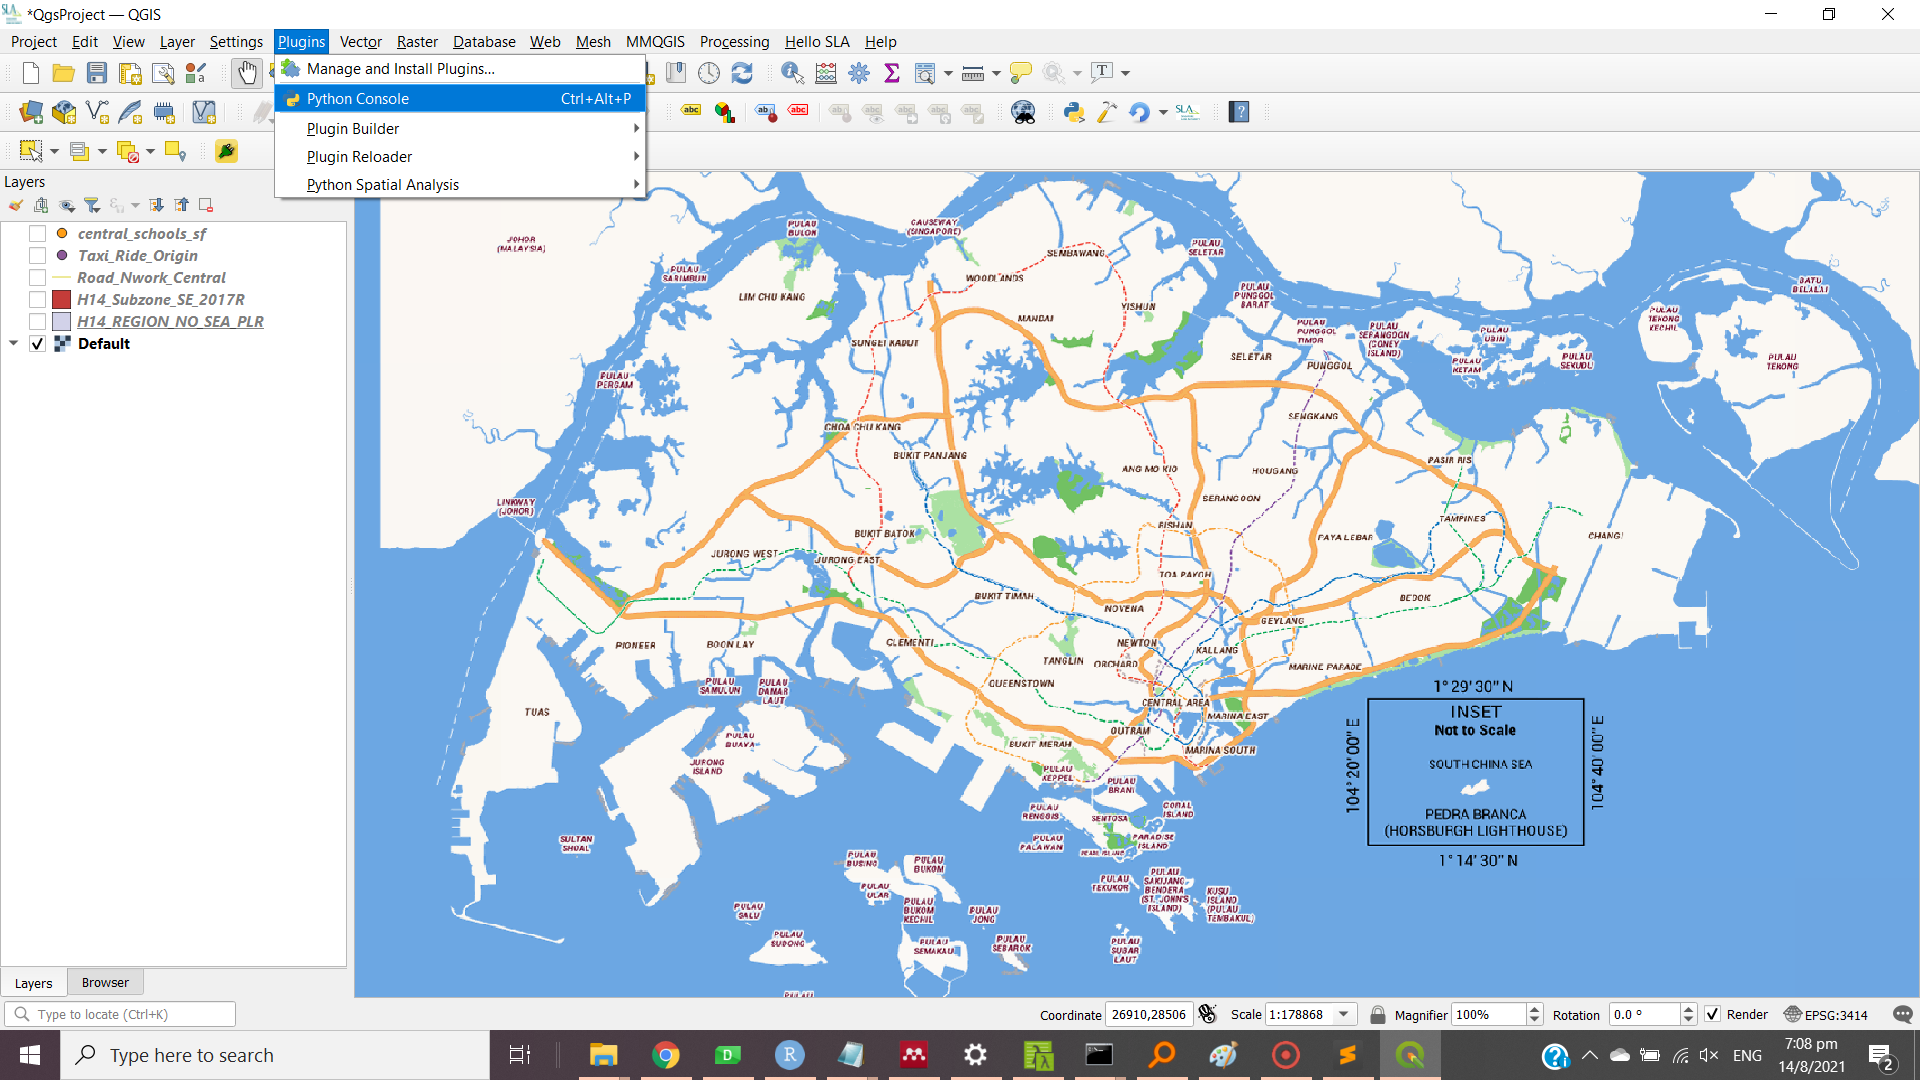
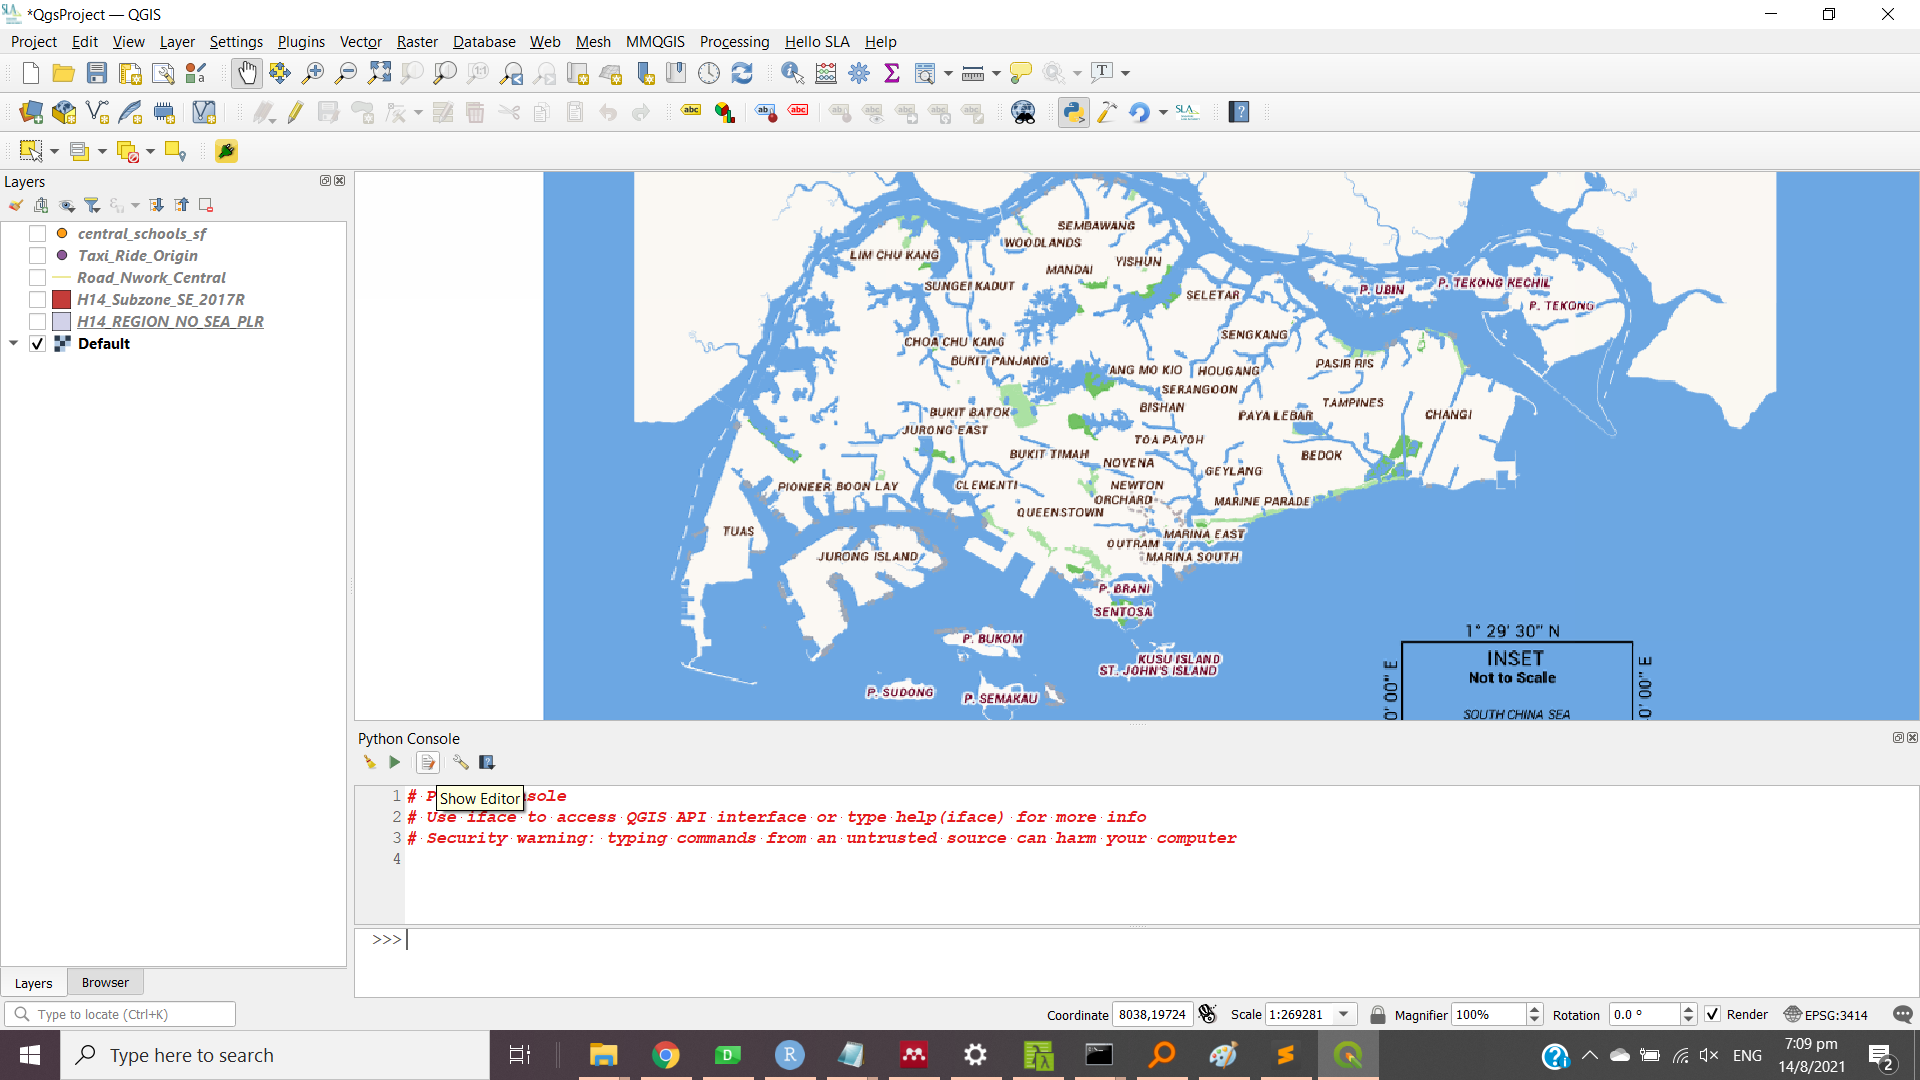
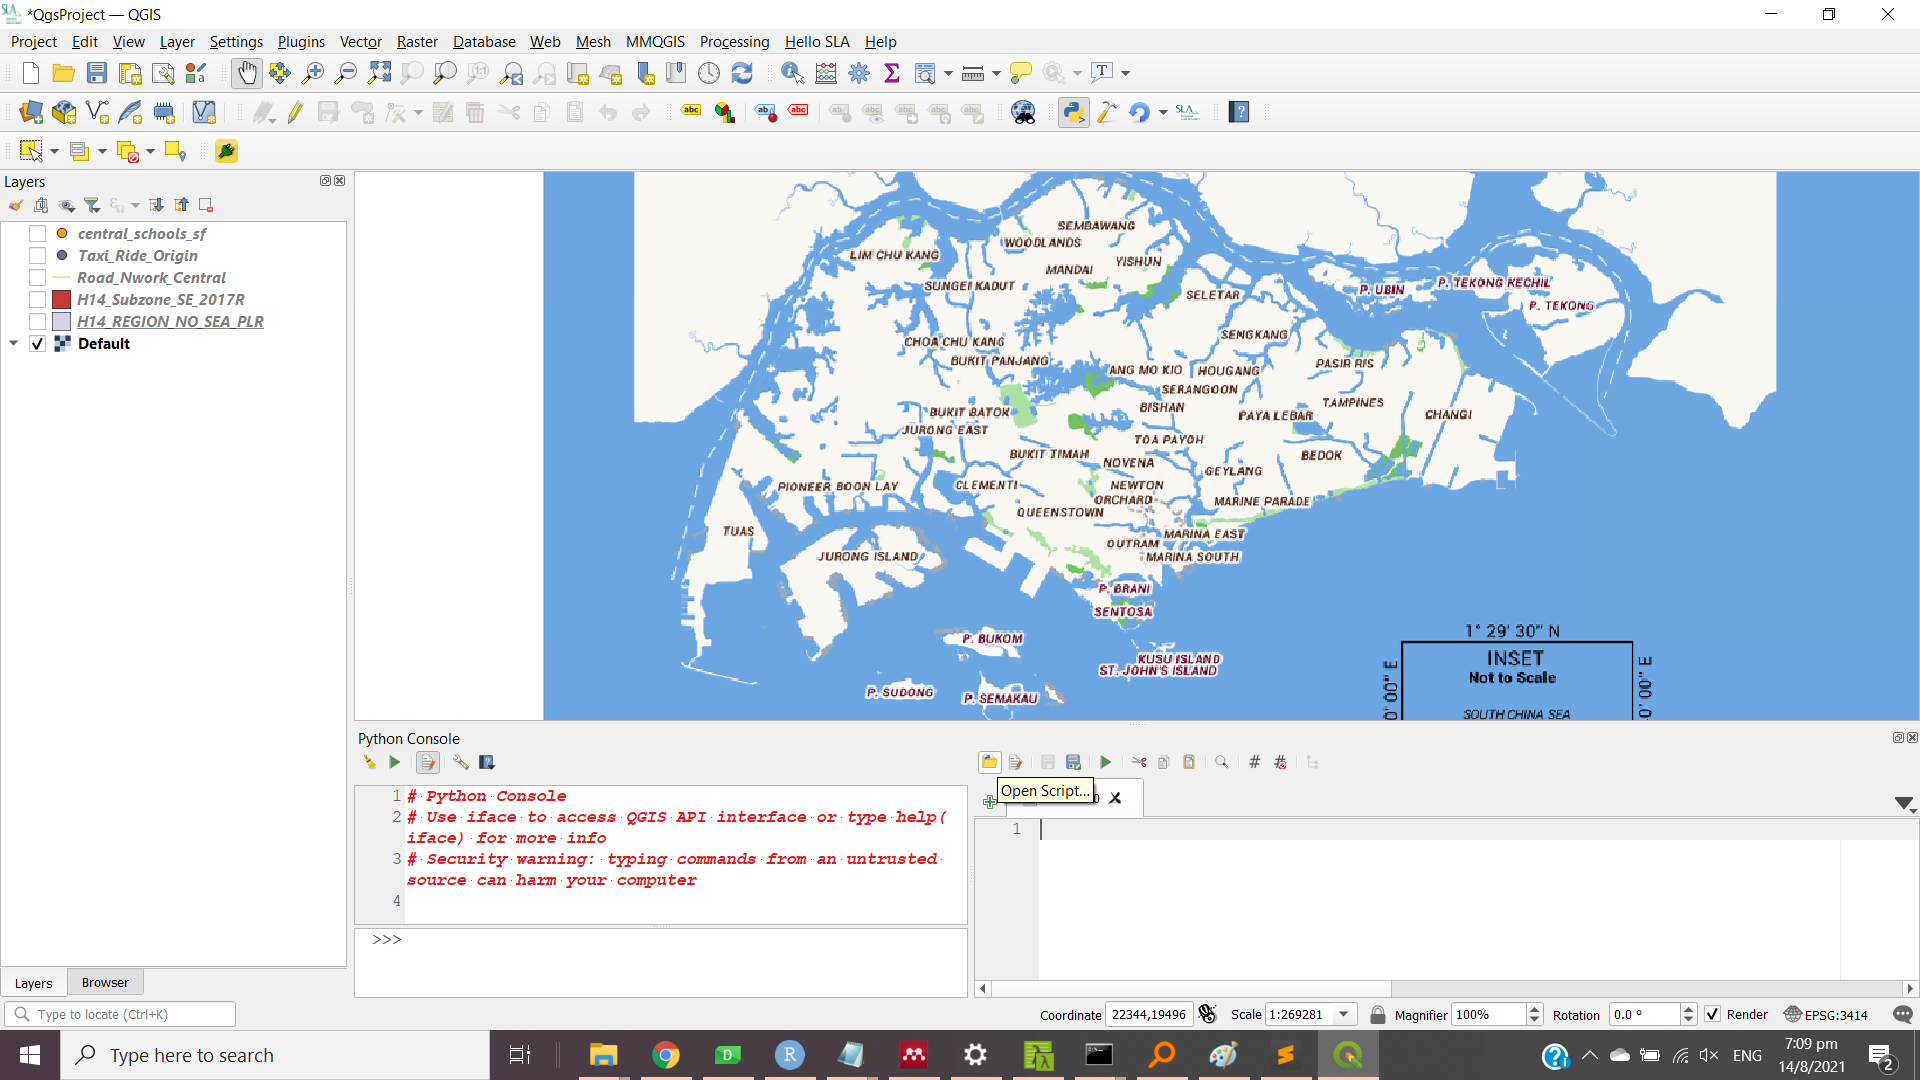

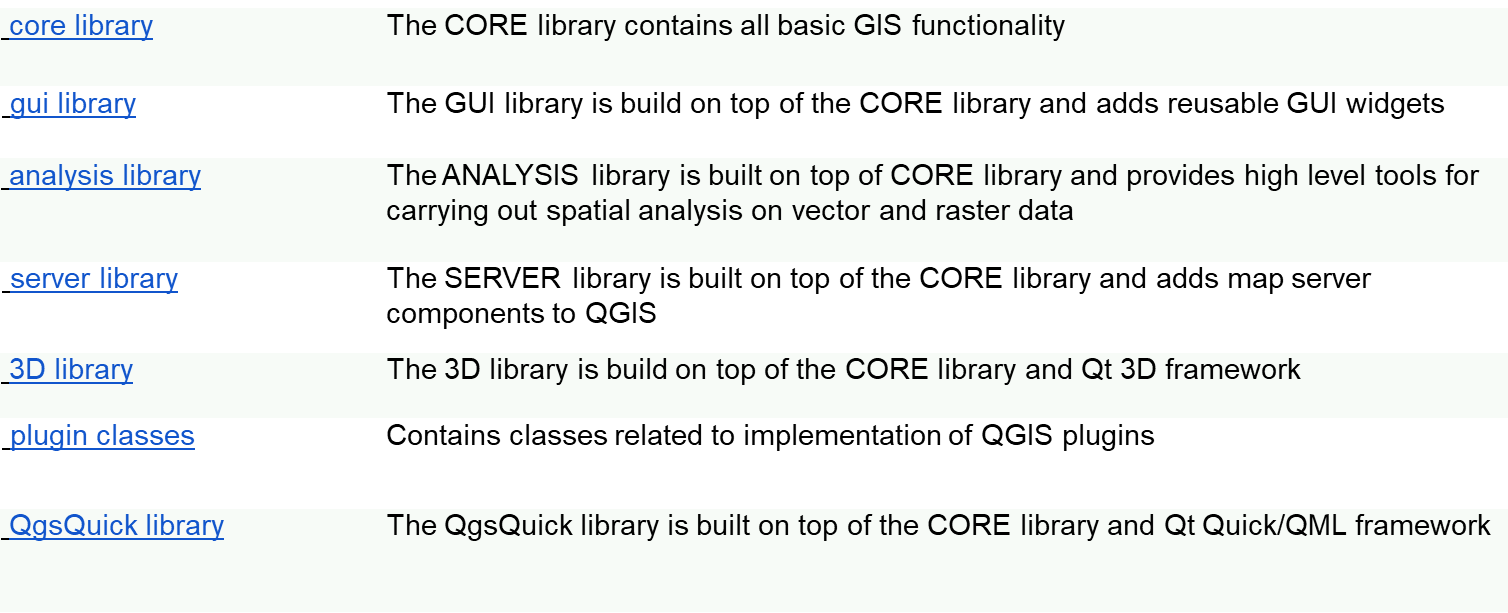

### QgisInterface

A reference to `QgisInterface` is typically available through the iface global variable.

Get a reference to the map canvas displayed within the main application window, using the `mapCanvas()` method.

Retrieve the currently active layer within the project, using the `activeLayer()` method.

Get a reference to the application’s main window by calling the `mainWindow()` method. 

Get a reference to the QGIS system’s message bar by calling the `messageBar()` method. 

```python
widget = iface.messageBar().createMessage('Hello World')

prgBar = QProgressBar()
prgBar.setValue(1)
prgBar.setMaximum(10)

widget.layout().addWidget(prgBar)
iface.messageBar().pushWidget(widget)
QApplication.setOverrideCursor(QCursor(Qt.WaitCursor))

# use the following line to change the cursor back
count =1
def bar():
    global count
    if count<=10:
        prgBar.setValue(count)
        count+=1
    else:
        timer.stop()
        iface.messageBar().clearWidgets()
        QApplication.setOverrideCursor(QCursor(Qt.ArrowCursor))
        
timer = QTimer()
timer.setInterval(1000)
timer.timeout.connect(bar)
timer.start()
```

Note that, The QgisInterface object is only available when running the QGIS application itself. If you are running an external application and import the PyQGIS library into your application, QgisInterface won’t be available.

### QgsProject

Encapsulates a QGIS project, including sets of map layers and their styles, layouts, annotations, canvases, etc.

QgsProject is available both as a singleton (QgsProject.instance()) and for use as standalone objects. The QGIS project singleton always gives access to the canonical project reference open within the main QGIS application.

```python
import os

# change your current work directory
os.chdir(r"C:\Users\user\Desktop\Projects\qgis-vanguard")

# as QgsProject is Singleton class, we need to get the instance of it
project = QgsProject.instance()

# open the project
project_name = 'Data/QgsProject.qgs'
project.read(project_name)
```

### QgsMapLayer

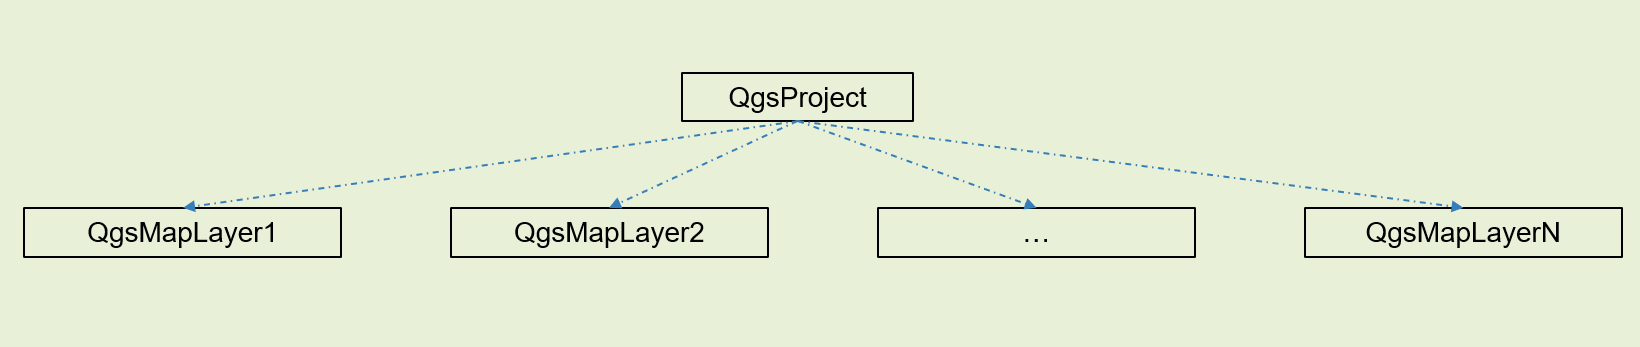

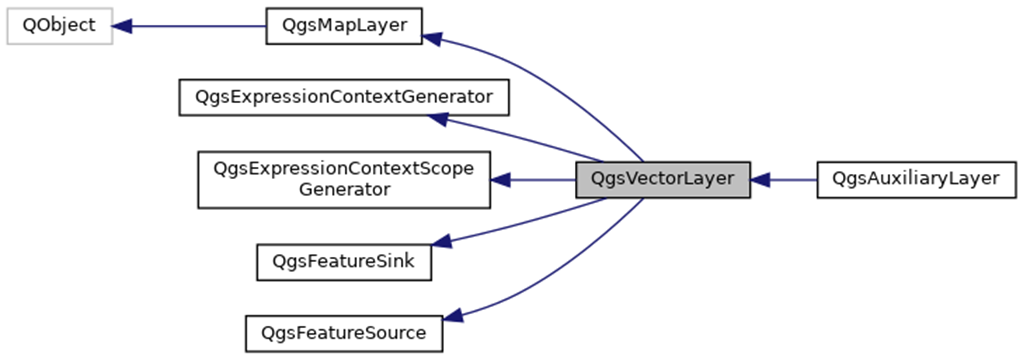

Base class for all map layer types. This is the base class for all map layer types (vector, raster).
```python
# list of layer names using list comprehension
layers = project.mapLayers()
l=[layer.name() for layer in layers.values()]

# dictionary with key = layer name and value = layer object
layers_list = {}
for l in layers.values():
    layers_list[l.name()] = l

print(layers_list)

### check layer type
# l.type()
```

### QgsFeature 

The feature class encapsulates a single feature including its id, geometry and a list of field/values attributes.

example
```python
# use QgsInterface global variable iface to get active layer
layer = iface.activeLayer()

# Check if a layer is selected
if not layer:
    iface.messageBar().pushMessage('Please select a layer',  level=Qgis.Critical) 
# Check if the selected layer is a vector layer
if layer.type() != QgsMapLayer.VectorLayer:
    iface.messageBar().pushMessage('Please select a vector layer',  level=Qgis.Critical)

features = layer.getFeatures()

for feature in features:
    # retrieve every feature with its geometry and attributes
    print("Feature ID: ", feature.id())

    # fetch attributes
    attrs = feature.attributes()

    # attrs is a list. It contains all the attribute values of this feature
    print(attrs)
```

Example: Summing values in one field

Method 1:
```python
layer = iface.activeLayer()

if not layer.isValid():
    raise Exception('Layer is not valid')

features = layer.getFeatures()

total = []
for feature in features:
    attr = feature.attributes()[6]

    if attr != NULL:
        total.append((int(attr)))
        
print(sum(total))
```

Method 2:
```python
total_sum = layer.aggregate(QgsAggregateCalculator.Sum, "BET0TO2")
print(total_sum[0])
```

Method 3:
```python
v = QgsVectorLayerUtils.getValues(layer, 'BET0TO2')[0]
v = list(filter(None, v))
print(s = sum(v))
```

### QgsGeometry

QgsGeometry acts as a generic container for geometry objects. QgsGeometry objects are implicitly shared, so making copies of geometries is inexpensive. 

The actual geometry representation is stored as a QgsAbstractGeometry within the container, and can be accessed via the get() method or set using the set() method. This gives access to the underlying raw geometry primitive, such as the point, line, polygon, curve or other geometry subclasses.

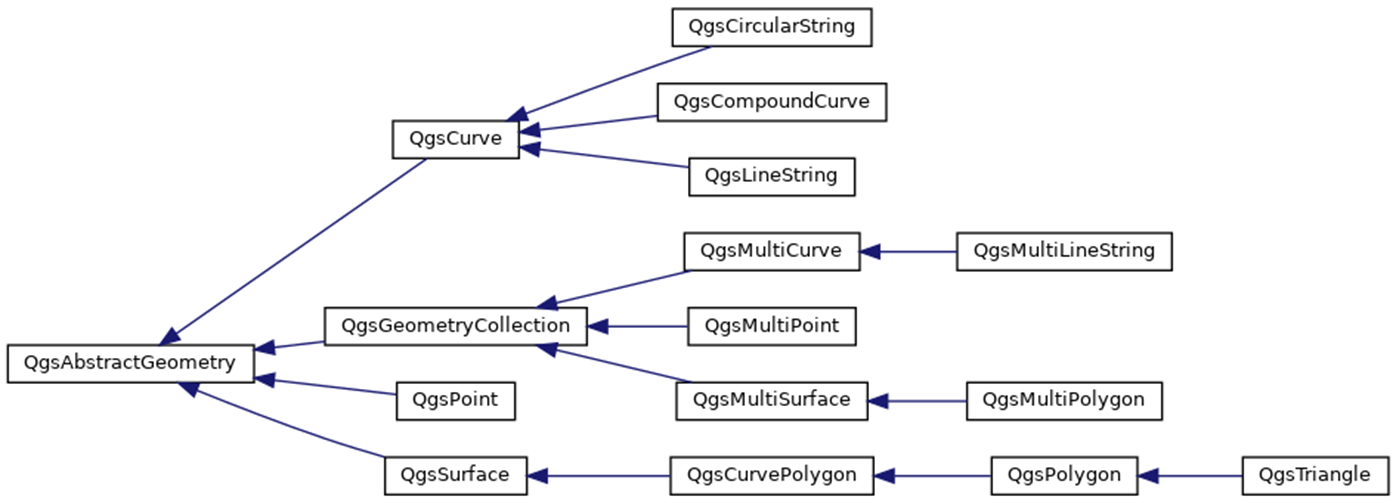

Creating a geometry:

```python
gPnt = QgsGeometry.fromPointXY(QgsPointXY(1,1))
print(gPnt)
gLine = QgsGeometry.fromPolyline([QgsPoint(1, 1), QgsPoint(2, 2)])
print(gLine)
gPolygon = QgsGeometry.fromPolygonXY([[QgsPointXY(1, 1),
    QgsPointXY(2, 2), QgsPointXY(2, 1)]])
print(gPolygon)
```

Geometry Predicates and Operations:

QGIS uses GEOS library for advanced geometry operations such as geometry predicates (contains(), intersects(), …) and set operations (combine(), difference(), …). It can also compute geometric properties of geometries, such as area (in the case of polygons) or lengths (for polygons and lines).

```python
# let's access the 'MP14_Subzone_SE_2017' layer
layer = QgsProject.instance().mapLayersByName('MP14_Subzone_SE_2017')[0]

# let's filter for countries that begin with MARINA, then get their features
query = '"SUBZONE_N" LIKE \'MARINA%\''
features = layer.getFeatures(QgsFeatureRequest().setFilterExpression(query))

# now loop through the features, perform geometry computation and print the results
for f in features:
    geom = f.geometry()
    name = f.attribute('SUBZONE_N')
    print(name)
    print('Area: ', geom.area())
    print('Perimeter: ', geom.length())
```

### Exercise PYQGIS Create a Dashboard

First, install bs4 via
```python
pip install beautifulsoup4
```

Next, copy the code into QGIS console.

```python
a = QgsHtmlAnnotation()
a.fillSymbol().symbolLayer(0).setStrokeColor(QColor(0, 0, 0))
a.setFrameSize(QSizeF(200, 440)) #dashboard size
a.setRelativePosition(QPointF(0, 0)) # dashboard relative location
#a.setRelativePosition(QPointF(0, 0.25)) # dashboard relative location
a.setHasFixedMapPosition(False)
html = "Code/PYQGIS/Dashboard/dashboard.html"
a.setSourceFile(html)

QgsProject.instance().annotationManager().addAnnotation(a)

######## parse html and update
from bs4 import BeautifulSoup

with open(html) as f:
    #read File
    content = f.read()
    print(content)
    #parse HTML
    soup = BeautifulSoup(content, 'html.parser')

# add feature selection change event
lyr=iface.activeLayer()
def myFunction(selFeatures):
    soup.find('div', id = "value1").string = str(len(selFeatures))
    print(str(len(selFeatures)) + " features were selected: " + str(selFeatures))
    with open(html,'w', encoding='utf-8') as infile:
        infile.write(str(soup))  # OR infile.write(a.prettify())
    a.setSourceFile(html)
    
lyr.selectionChanged.connect(myFunction)
myFunction(lyr.selectedFeatures()) # clean 
```

### Exercise PYQGIS Change Layer Name (optional)

1. Read a QGIS Project. You can use your own qgis project file. Just ensure that the file path is correct. 
2. Change the layer names of only **selected layers** by adding "QGIS_" at the beginning of all these layeres
hint:
    >iface.layerTreeView().selectedLayers() #all selected layers
3. Move these layers to the top of the TOC.
    > first clone the selected layers nodes  
    insert the layers to the top of the toc  
    remove the orginal layers

## Standalone PYQGIS

### Import relevant modules

In [3]:
print(sys.path)

['C:\\Users\\user\\Desktop\\Projects\\qgis-vanguard', 'C:\\PROGRA~1\\QGIS32~2.3\\bin\\python39.zip', 'C:\\PROGRA~1\\QGIS32~2.3\\apps\\Python39\\DLLs', 'C:\\PROGRA~1\\QGIS32~2.3\\apps\\Python39\\lib', 'C:\\PROGRA~1\\QGIS32~2.3\\bin', '', 'C:\\Users\\user\\AppData\\Roaming\\Python\\Python39\\site-packages', 'C:\\PROGRA~1\\QGIS32~2.3\\apps\\Python39', 'C:\\PROGRA~1\\QGIS32~2.3\\apps\\Python39\\lib\\site-packages', 'C:\\PROGRA~1\\QGIS32~2.3\\apps\\Python39\\lib\\site-packages\\GDAL-3.4.1-py3.9-win-amd64.egg', 'C:\\PROGRA~1\\QGIS32~2.3\\apps\\Python39\\lib\\site-packages\\win32', 'C:\\PROGRA~1\\QGIS32~2.3\\apps\\Python39\\lib\\site-packages\\win32\\lib', 'C:\\PROGRA~1\\QGIS32~2.3\\apps\\Python39\\lib\\site-packages\\Pythonwin', 'C:\\Users\\user\\AppData\\Roaming\\Python\\Python39\\site-packages\\IPython\\extensions', 'C:\\Users\\user\\.ipython', 'C:\\Program Files\\QGIS 3.22.3\\apps\\qgis\\python', 'C:\\Program Files\\QGIS 3.22.3\\apps\\qgis\\python\\plugins']


In [4]:
os.getcwd()

'C:\\Users\\user\\Desktop\\Projects\\qgis-vanguard'

### PyQT MessageBox example

In [5]:
from PyQt5.QtGui import *
from PyQt5.QtWidgets import *

In [6]:
QApplication?

Init signature: QApplication(self, /, *args, **kwargs)
Docstring:      QApplication(List[str])
File:           c:\progra~1\qgis32~2.3\apps\python39\lib\site-packages\pyqt5\qtwidgets.pyd
Type:           wrappertype
Subclasses:     QgsApplication


In [7]:
def window():
    app = QApplication(sys.argv)
    w = QWidget()
    b = QPushButton(w)
    b.setText("Show message!")

    b.move(50,50)
    b.clicked.connect(showdialog)
    w.setWindowTitle("PyQt Dialog demo")
    w.show()
    sys.exit(app.exec_())

def showdialog():
    msg = QMessageBox()
    msg.setIcon(QMessageBox.Information)

    msg.setText("This is a message box")
    msg.setInformativeText("This is additional information")
    msg.setWindowTitle("MessageBox demo")
    msg.setDetailedText("The details are as follows:")
    msg.setStandardButtons(QMessageBox.Ok | QMessageBox.Cancel)
    msg.buttonClicked.connect(msgbtn)

    retval = msg.exec_()
    print("value of pressed message box button:", retval)

def msgbtn(i):
    print("Button pressed is:",i.text())

window()

value of pressed message box button: 4194304


SystemExit: 0

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3449: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### Visualize the layer using a map canvas 

In [ ]:
QgsApplication.setPrefixPath(r'C:\Program Files\QGIS 3.22.3\apps\qgis', True)
qgs = QgsApplication([], True)
qgs.initQgis()

In [37]:
canvas = QgsMapCanvas()
canvas.show()
canvas.setCanvasColor(Qt.white)
canvas.enableAntiAliasing(True)

layer = QgsVectorLayer(r"Data\MP14_Subzone_Y_2017.shp", "SocioEcon", "ogr")

if not layer.isValid():
    raise IOError("Failed to open the layer")

# add layer to the registry
QgsProject.instance().addMapLayer(layer)

# set extent to the extent of our layer
canvas.setExtent(layer.extent())

# set the map canvas layer set
canvas.setLayers([layer])
qgs.exec_()

0

In [38]:
QgsProject.instance().mapLayers().values()

dict_values([<QgsVectorLayer: 'SocioEcon' (ogr)>])

### Create a QGIS Map Application using Map Canvas 

The Map canvas shows the map composed from overlaid map layers and allows interaction with the map and layers. The map canvas is implemented with the QgsMapCanvas class in the qgis.gui module. In the following example, class MyWnd is essentially a QMainWindow (PyQt Window object) that contains a QgsMapCanvas. 

In [39]:
class MyWnd(QMainWindow):
    def __init__(self, layer):
        QMainWindow.__init__(self)

        self.canvas = QgsMapCanvas()
        self.canvas.setCanvasColor(Qt.white)

        self.canvas.setExtent(layer.extent())
        self.canvas.setLayers([layer])

        self.setCentralWidget(self.canvas)
        
        # add menu
        menubar = self.menuBar()
        menu_file = menubar.addMenu('File')
        open_action = menu_file.addAction("Open project")
        menu_help = menubar.addMenu('Help')
        open_action = menu_help.addAction("About")
        
        #there is always one tool active and the user can switch between the available tools.
        self.actionZoomIn = QAction("Zoom in", self)
        self.actionZoomOut = QAction("Zoom out", self)
        self.actionPan = QAction("Pan", self)
        
        # setcheckable means that users need to check the button and then interact with the map canvas
        self.actionZoomIn.setCheckable(True)
        self.actionZoomOut.setCheckable(True)
        self.actionPan.setCheckable(True)
        
        # triggered connect action with a function 
        self.actionZoomIn.triggered.connect(self.zoomIn)
        self.actionZoomOut.triggered.connect(self.zoomOut)
        self.actionPan.triggered.connect(self.pan)
        
        # add a toolbar to contain all the buttons
        self.toolbar = self.addToolBar("Canvas actions")
        self.toolbar.addAction(self.actionZoomIn)
        self.toolbar.addAction(self.actionZoomOut)
        self.toolbar.addAction(self.actionPan)

        # create the map tools
        self.toolPan = QgsMapToolPan(self.canvas)
        self.toolPan.setAction(self.actionPan)
        self.toolZoomIn = QgsMapToolZoom(self.canvas, False) # false = in
        self.toolZoomIn.setAction(self.actionZoomIn)
        self.toolZoomOut = QgsMapToolZoom(self.canvas, True) # true = out
        self.toolZoomOut.setAction(self.actionZoomOut)

        self.pan()
        self.initUI()

    def initUI(self):
        self.setWindowTitle('Map Canvas Example')
        
        self.my_act = QAction(QIcon('Resources/sla.png'), 'Identify', self)
        self.my_act.setCheckable(True)
        self.my_act.triggered.connect(self.identify)
        self.toolbar2 = self.addToolBar('Identify')
        self.toolbar2.addAction(self.my_act)
        
        self.toolIdentify = QgsMapToolIdentifyFeature(self.canvas)
        self.toolIdentify.setAction(self.my_act)

        self.toolIdentify.setLayer(layer)
        self.toolIdentify.featureIdentified.connect(self.onFeatureIdentified)

    def zoomIn(self):
        self.canvas.setMapTool(self.toolZoomIn)

    def zoomOut(self):
        self.canvas.setMapTool(self.toolZoomOut)

    def pan(self):
        self.canvas.setMapTool(self.toolPan)
        
    def identify(self):
        self.canvas.setMapTool(self.toolIdentify)
        
    def onFeatureIdentified(self,feature):
        self.fid = feature.id()
        print("feature selected ID is: " + str(self.fid))
        
    def getCanvas(self):
        return self.canvas
        
vlayer =QgsVectorLayer("Data/MP14_REGION_NO_SEA_PL.shp","MP14_REGION_NO_SEA_PL","ogr")
w = MyWnd(vlayer)
w.show()
qgs.exec_()

feature selected ID is: 204
feature selected ID is: 208
feature selected ID is: 217
feature selected ID is: 161


0

The map canvas architecture consists of three concepts:

* map canvas — for viewing of the map
* map canvas items — additional items that can be displayed on the map canvas
* map tools — for interaction with the map canvas

To show some additional data on top of the map in canvas, use map canvas items. 

### Map canvas items 

There are two useful canvas item classes for map canvas items: QgsRubberBand for drawing polylines or polygons, and QgsVertexMarker for drawing points. 

In [40]:
class MyWndDrawItem(MyWnd):
    def __init__(self,layer):
        super().__init__(layer)
    
    def initUI(self):
        super().initUI()
        self.my_tool_item_rect = QAction(QIcon('Resources/icons8-rectangle-48.png'), 'Rectangle Item', self)
        self.my_tool_item_rect.setCheckable(False)
        self.my_tool_item_rect.triggered.connect(self.rectItem)
        self.toolbar2.addAction(self.my_tool_item_rect)
        
    def rectItem(self):
        r = QgsRubberBand(self.canvas,True)  # True = a polygon
        points = [[QgsPointXY(44167,24960), QgsPointXY(46692,24960), QgsPointXY(46692,21808), QgsPointXY(44167,21808)]]
        r.setToGeometry(QgsGeometry.fromPolygonXY(points), None)
        
        # we can change the color and width of the rectangle
#         r.setColor(QColor(0, 0, 255))
#         r.setWidth(3)
        
w2 = MyWndDrawItem(vlayer)
w2.show()
qgs.exec_()

0

### Writing Custom Map Canvas Items

In [41]:
class CircleCanvasItem(QgsMapCanvasItem):
    def __init__(self, canvas):
        super().__init__(canvas)
        self.center = QgsPoint(0,0)
        self.size   = 80

    def setCenter(self, center):
        self.center = center

    def center(self):
        return self.center

    def setSize(self, size):
        self.size = size

    def size(self):
        return self.size

    def boundingRect(self):
        return QRectF(self.center.x() - self.size/2,
          self.center.y() - self.size/2,
          self.center.x() + self.size/2,
          self.center.y() + self.size/2)

    def paint(self, painter, option, widget):
        path = QPainterPath()
        path.moveTo(self.center.x(), self.center.y());
        path.arcTo(self.boundingRect(), 0.0, 360.0)
        painter.fillPath(path, QColor("red"))

In [42]:
class MyWndDrawCircle(MyWndDrawItem):
    def __init__(self,layer):
        super().__init__(layer)
    
    def initUI(self):
        super().initUI()
        self.my_tool_item_circle = QAction(QIcon('Resources/icons8-circle-48.png'), 'Circle Item', self)
        self.my_tool_item_circle.setCheckable(False)
        self.my_tool_item_circle.triggered.connect(self.circleItem)
        self.toolbar2.addAction(self.my_tool_item_circle)
    
    # wait until the next cell class CircleCanvasItem created
    def circleItem(self):
        item = CircleCanvasItem(self.canvas)
        item.setCenter(QgsPointXY(80,80))
        item.setSize(80)
        
w3 = MyWndDrawCircle(vlayer)
w3.show()
qgs.exec_()

0

### Writing Custom Map Tools

Custom map tools should inherit from the QgsMapTool or derived class. We can implement custom behaviors to actions performed by users on the canvas. Here is an example. Its allows us to define a rectangular extent by clicking and dragging on the canvas. When the rectangle is defined, it prints its boundary coordinates in the console. 

In [43]:
class PolyMapTool(QgsMapToolEmitPoint):

    def __init__(self, canvas):
        self.canvas = canvas
        QgsMapToolEmitPoint.__init__(self, self.canvas)
#         self.rubberband = QgsRubberBand(self.canvas, QgsWkbTypes.LineGeometry)
        self.rubberband = QgsRubberBand(self.canvas, QgsWkbTypes.PolygonGeometry)
        self.rubberband.setColor(Qt.red)
        self.rubberband.setWidth(1)
        self.point = None
        self.points = []

    def canvasPressEvent(self, e):
        self.point = self.toMapCoordinates(e.pos())
        m = QgsVertexMarker(self.canvas)
        m.setCenter(self.point)
        m.setColor(QColor(0,255,0))
        m.setIconSize(5)
        m.setIconType(QgsVertexMarker.ICON_BOX)
        m.setPenWidth(3)
        self.points.append(self.point)
        self.isEmittingPoint = True
        self.showPoly()
    
    def showPoly(self):
#         self.rubberband.reset(QgsWkbTypes.LineGeometry)
        self.rubberband.reset(QgsWkbTypes.PolygonGeometry)
        for point in self.points[:-1]:
            self.rubberband.addPoint(point, False)
            # if we add the two lines here, it be another interesting drawtool
            self.rubberband.addPoint(self.points[-1], True)
            self.rubberband.show()
        self.rubberband.addPoint(self.points[-1], True)
        self.rubberband.show()

In [44]:
class MyWndDrawPolyTool(MyWndDrawCircle):
    def __init__(self,layer):
        super().__init__(layer)
    
    def initUI(self):
        super().initUI()
        
        # First we define our polygon tool’s button in the actions portion of our application. 
        self.my_poly_tool = QAction(QIcon('Resources/icons8-polygon-64.png'), 'Poly Tool', self)
        
        # we make sure that when you click the button, it stays selected:
        self.my_poly_tool.setCheckable(True)
        
        # we define the method used when the button is triggered
        self.my_poly_tool.triggered.connect(self.poly)
        self.toolbar2.addAction(self.my_poly_tool)
        
        # Then we link the application to our specialized tool class:
        self.toolPoly = PolyMapTool(self.canvas)
        self.toolPoly.setAction(self.my_poly_tool)

    # we define the method in the main application class for our tool:
    def poly(self):
        self.canvas.setMapTool(self.toolPoly)
        
w4 = MyWndDrawPolyTool(vlayer)
w4.show()
qgs.exec_()

0

For more examples on rubberband, see https://www.programcreek.com/python/example/100665/qgis.gui.QgsRubberBand

### Exercise Create a Custom Map Tool Application (optional)

1. Create a QGIS Mapp Application using mapcanvas
2. Add a Custom Map tool. 
3. Users choose the tool and click at certain location of the map, then the system creates a rectangle canvas item at the location.

## Geoprocessing (optional)

In [59]:
import processing
from processing.core.Processing import Processing
Processing.initialize()
QgsApplication.processingRegistry().addProvider(QgsNativeAlgorithms())
for alg in QgsApplication.processingRegistry().algorithms():
        print(alg.id(), "--->", alg.displayName())

3d:tessellate ---> Tessellate
gdal:aspect ---> Aspect
gdal:assignprojection ---> Assign projection
gdal:buffervectors ---> Buffer vectors
gdal:buildvirtualraster ---> Build virtual raster
gdal:buildvirtualvector ---> Build virtual vector
gdal:cliprasterbyextent ---> Clip raster by extent
gdal:cliprasterbymasklayer ---> Clip raster by mask layer
gdal:clipvectorbyextent ---> Clip vector by extent
gdal:clipvectorbypolygon ---> Clip vector by mask layer
gdal:colorrelief ---> Color relief
gdal:contour ---> Contour
gdal:contour_polygon ---> Contour Polygons
gdal:convertformat ---> Convert format
gdal:dissolve ---> Dissolve
gdal:executesql ---> Execute SQL
gdal:extractprojection ---> Extract projection
gdal:fillnodata ---> Fill nodata
gdal:gdal2tiles ---> gdal2tiles
gdal:gdal2xyz ---> gdal2xyz
gdal:gdalinfo ---> Raster information
gdal:gridaverage ---> Grid (Moving average)
gdal:griddatametrics ---> Grid (Data metrics)
gdal:gridinversedistance ---> Grid (Inverse distance to a power)
gdal:grid

In [60]:
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\geopandas\plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


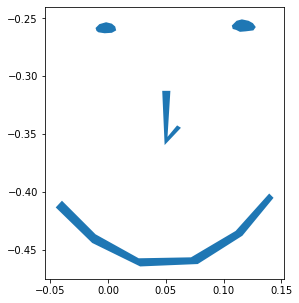

In [61]:
source = r"Data\smile.geojson"
inputvector = QgsVectorLayer(source)
fig, ax = plt.subplots(figsize = (5,5))
gpd.read_file(source).plot(ax=ax);

In [62]:
processing.algorithmHelp("native:extractvertices")

Extract vertices (native:extractvertices)

This algorithm takes a line or polygon layer and generates a point layer with points representing the vertices in the input lines or polygons. The attributes associated to each point are the same ones associated to the line or polygon that the point belongs to.

Additional fields are added to the point indicating the vertex index (beginning at 0), the vertex’s part and its index within the part (as well as its ring for polygons), distance along original geometry and bisector angle of vertex for original geometry.


----------------
Input parameters
----------------

INPUT: Input layer

	Parameter type:	QgsProcessingParameterFeatureSource

	Accepted data types:
		- str: layer ID
		- str: layer name
		- str: layer source
		- QgsProcessingFeatureSourceDefinition
		- QgsProperty
		- QgsVectorLayer

OUTPUT: Vertices

	Parameter type:	QgsProcessingParameterFeatureSink

	Accepted data types:
		- str: destination vector file, e.g. 'd:/test.shp'
		- st

In [63]:
vertice_out = r"Data\smile_vertices.geojson"
# just delete the output if exist
if os.path.exists(vertice_out):
    os.remove(vertice_out)
else:
    pass
params = {
    'INPUT': inputvector,
    'OUTPUT': vertice_out
}
feedback = QgsProcessingFeedback()
results = processing.run("native:extractvertices", params, feedback=feedback)

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\geopandas\plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


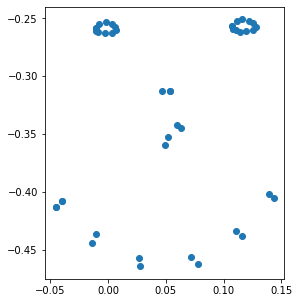

In [64]:
fig, ax = plt.subplots(figsize = (5,5))
gpd.read_file(vertice_out).plot(ax=ax);

In [65]:
processing.algorithmHelp("native:buffer") 

Buffer (native:buffer)

This algorithm computes a buffer area for all the features in an input layer, using a fixed or dynamic distance.

The segments parameter controls the number of line segments to use to approximate a quarter circle when creating rounded offsets.

The end cap style parameter controls how line endings are handled in the buffer.

The join style parameter specifies whether round, miter or beveled joins should be used when offsetting corners in a line.

The miter limit parameter is only applicable for miter join styles, and controls the maximum distance from the offset curve to use when creating a mitered join.


----------------
Input parameters
----------------

INPUT: Input layer

	Parameter type:	QgsProcessingParameterFeatureSource

	Accepted data types:
		- str: layer ID
		- str: layer name
		- str: layer source
		- QgsProcessingFeatureSourceDefinition
		- QgsProperty
		- QgsVectorLayer

DISTANCE: Distance

	Parameter type:	QgsProcessingParameterDistance

	Accepte

In [66]:
buffer_out = r"Data\smile_vertices_hahaha22.geojson"

# just delete the output if exist
if os.path.exists(buffer_out):
    os.remove(buffer_out)
else:
    pass

In [67]:
source = r'Data\smile_vertices.geojson'
inputvector = QgsVectorLayer(source, 'smile_vertices','ogr')
inputvector

<QgsVectorLayer: 'smile_vertices' (ogr)>

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\geopandas\plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


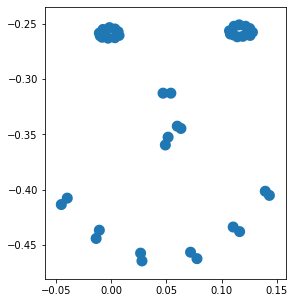

In [71]:
params = { 'DISSOLVE' : True, 
          'DISTANCE' : 0.005, 
          'END_CAP_STYLE' : 0, 
          'INPUT' : inputvector, 
          'JOIN_STYLE' : 0, 
          'MITER_LIMIT' : 2, 
          'OUTPUT' : buffer_out, 
          'SEGMENTS' : 10 }

feedback = QgsProcessingFeedback()
processing.run("native:buffer", params, feedback=feedback)
fig, ax = plt.subplots(figsize = (10,5))
gpd.read_file(buffer_out).plot(ax=ax,aspect='equal');

In [ ]:
# Finally, exitQgis() is called to remove the
# provider and layer registries from memory
qgs.exitQgis()
qgs.exit()